In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.set_default_device('cuda')

In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param,
                 regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss

In [4]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # self.alpha_f = 0.05
        # self.alpha_s = 0.08
        # self.h_f = 5
        # self.h_s = 6
        # self.t_hot = 4
        # self.u_f = 1

        self.t_0 = 293.15

        self.u = torch.tensor([0.0, 1.0]).repeat(n_int, 1).T


        self.rho_l = 998 # Density Fluid

        self.C_f = 4180 # Heat capacity fluid

        self.k_t = 0.598 # Thermal conductivity Fluid
        self.k_b = 149 # Thermal conductivity Solid

        self.H_t = 0.5 * 380e-6 # Half-Thickness Fluid
        self.H_b = 0.5 * 150e-6 # Half-Thickness Solid

        self.h_b = self.k_b / self.H_b
        self.h_t = 35 * self.k_t / (26 * self.H_t)

        self.q_in = 1e5 # heat-source die layer



        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]]).to('cuda')  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the PDE

        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.001,
                                              regularization_exp=2.,
                                              retrain_seed=42).to('cuda')

        # self.approximate_solution = self.approximate_solid

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return torch.full_like(x, self.t_0)

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb).to('cuda'))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb).to('cuda'))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        return input_sb_0, input_sb_L

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int).to('cuda'))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb_0, input_sb_L = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb_0, input_sb_L), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        output_tb = self.approximate_solution(input_tb)
        output_tb_s = output_tb[:, 0]
        output_tb_f = output_tb[:, 1]

        return output_tb_s, output_tb_f

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True

        t = self.approximate_solution(input_int)

        ts = t[:, 0]
        tf = t[:, 1]

        grad_ts = torch.autograd.grad(ts.sum(), input_int, create_graph=True)[0]
        grad_ts_y = grad_ts[:, 0]
        grad_ts_yy = torch.autograd.grad(grad_ts_y.sum(), input_int, create_graph=True)[0][:, 0]

        grad_ts_x = grad_ts[:, 1]
        grad_ts_xx = torch.autograd.grad(grad_ts_x.sum(), input_int, create_graph=True)[0][:, 1]

        grad_tf = torch.autograd.grad(tf.sum(), input_int, create_graph=True)[0]
        grad_tf_y = grad_tf[:, 0]
        grad_tf_yy = torch.autograd.grad(grad_tf_y.sum(), input_int, create_graph=True)[0][:, 0]

        grad_tf_x = grad_tf[:, 1]
        grad_tf_xx = torch.autograd.grad(grad_tf_x.sum(), input_int, create_graph=True)[0][:, 1]

        div_grad_tf = grad_tf_xx + grad_tf_yy
        div_grad_ts = grad_ts_xx + grad_ts_yy

        u_dot_grad_T = (self.u * grad_tf_x)

        residual = (2/3 * self.rho_l * self.C_f * u_dot_grad_T - 49 * self.k_t / 52 * div_grad_tf - 1 / (2 * self.H_t) * self.h_b * self.h_t / (self.h_b + self.h_t)*(ts - tf))**2
        residual += (- self.k_b/2 * div_grad_ts + 1 / (2 * self.H_b) * self.h_b * self.h_t / (self.h_b + self.h_t)*(ts - tf) - 1 / (2 * self.H_b) * self.q_in)**2


        # residual = (grad_tf_t + self.u_f * grad_tf_x - self.alpha_f * grad_tf_xx + self.h_f * (tf - ts))**2
        # residual+= (grad_ts_t                        - self.alpha_s * grad_ts_xx - self.h_s * (tf - ts))**2
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb_0, inp_train_sb_L, inp_train_tb, sol_tb, inp_train_int, verbose=True):

        pred_tb_solid, pred_tb_fluid = self.apply_initial_condition(inp_train_tb)

        inp_train_sb_0.requires_grad = True
        inp_train_sb_L.requires_grad = True

        t_0 = self.approximate_solution(inp_train_sb_0)

        # ts_0 = self.approximate_solution(inp_train_sb_0)[:, 0]
        # grad_ts = torch.autograd.grad(ts_0.sum(), inp_train_sb_0, create_graph=True)[0]
        # grad_ts_0_x = grad_ts[:, 1]

        t_L = self.approximate_solution(inp_train_sb_L)

        # ts_L = t_L[:, 0]
        # tf_L = t_L[:, 1]

        # grad_ts = torch.autograd.grad(ts_L.sum(), inp_train_sb_L, create_graph=True)[0]
        # grad_ts_L_x = grad_ts[:, 1]

        # grad_tf = torch.autograd.grad(tf_L.sum(), inp_train_sb_L, create_graph=True)[0]
        # grad_tf_L_x = grad_tf[:, 1]


        # train_fluid_boundary = (self.t_hot - self.t_0) / (1 + torch.exp(-200 * (inp_train_sb_0[:, 0] - 0.25))) + self.t_0



        # pred_fluid_boundary = self.approximate_solution(inp_train_sb_0)[:, 1]


        # r_sb = grad_ts_0_x ** 2 + grad_ts_L_x ** 2 + grad_tf_L_x ** 2 + (pred_fluid_boundary - train_fluid_boundary) ** 2

        r_sb = t_0**2 + t_L**2

        loss_sb = torch.mean(r_sb)


        r_int = self.compute_pde_residual(inp_train_int)


        # r_tb = torch.mean((pred_tb_solid - sol_tb)**2)
        r_tb = torch.mean((pred_tb_fluid - sol_tb)**2)

        loss_tb = r_tb # torch.mean(r_tb ** 2)

        loss_int = torch.mean(r_int ** 2)

        loss_u = loss_sb + loss_tb

        loss_reg = self.approximate_solution.regularization()

        loss = torch.log10(self.lambda_u * loss_u + loss_int + loss_reg)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| Boundary Error: ", round(loss_u.item(), 4), "| Interior Error: ", round(loss_int.item(), 4) , "| Regularization Error: ", round(loss_reg.item(), 4))

        return loss

    ################################################################################################
    def     fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb_0, inp_train_sb_L), (inp_train_tb, sol_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb_0, inp_train_sb_L, inp_train_tb, sol_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history



In [5]:
n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

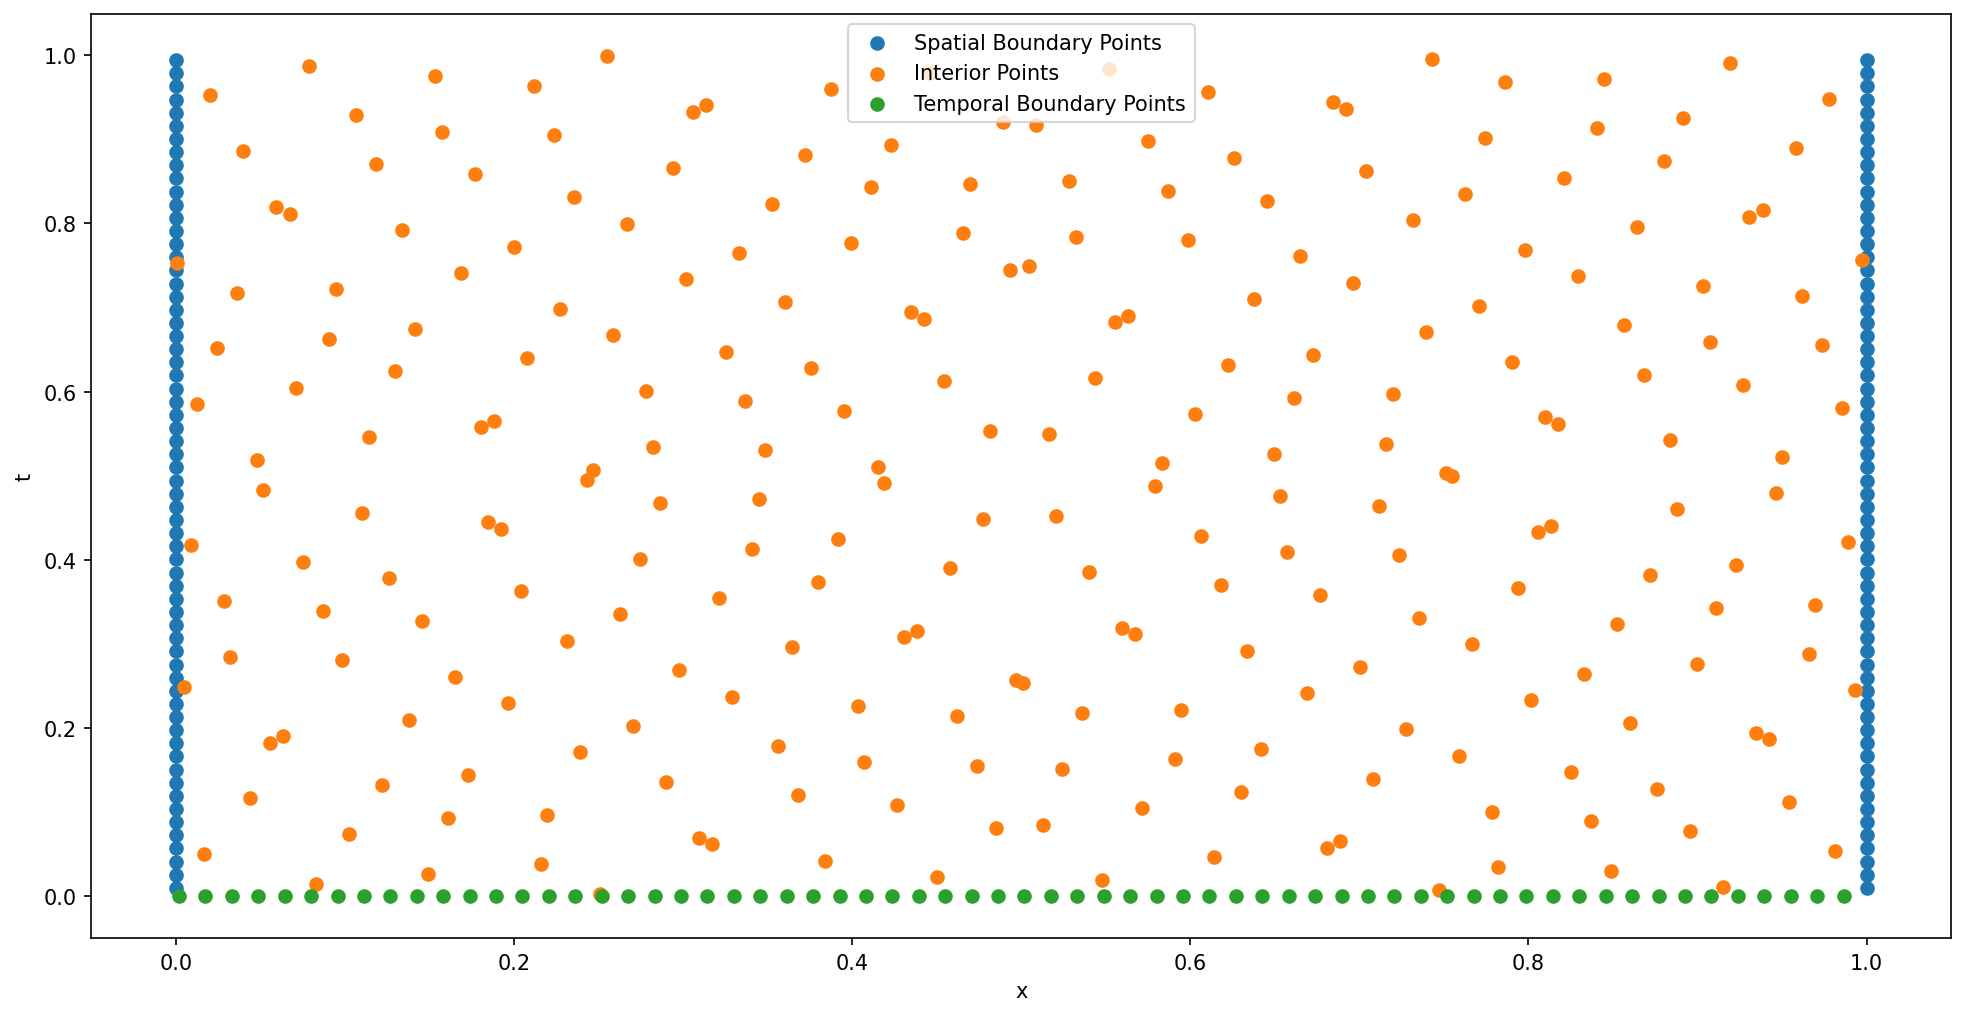

In [6]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(torch.cat([input_sb_, output_sb_], 0)[:, 1].detach().cpu().numpy(), torch.cat([input_sb_, output_sb_], 0)[:, 0].detach().cpu().numpy(), label="Spatial Boundary Points")
plt.scatter(input_int_[:, 1].detach().cpu().numpy(), input_int_[:, 0].detach().cpu().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().cpu().numpy(), input_tb_[:, 0].detach().cpu().numpy(), label="Temporal Boundary Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [7]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=10000,
                              max_eval=10000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))


hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

################################  0  ################################
Total loss:  35.6217 | Boundary Error:  86234.9609 | Interior Error:  4.1854938914420616e+35 | Regularization Error:  0.0289
Total loss:  35.604 | Boundary Error:  86324.1094 | Interior Error:  4.018141828326431e+35 | Regularization Error:  0.0289
Total loss:  35.4231 | Boundary Error:  87033.1094 | Interior Error:  2.6489219121773527e+35 | Regularization Error:  0.0289
Total loss:  35.145 | Boundary Error:  87717.9688 | Interior Error:  1.3963161457993633e+35 | Regularization Error:  0.0289
Total loss:  34.6692 | Boundary Error:  88350.2734 | Interior Error:  4.668885906404655e+34 | Regularization Error:  0.0289
Total loss:  34.4035 | Boundary Error:  89148.1484 | Interior Error:  2.5320171931202425e+34 | Regularization Error:  0.0291
Total loss:  33.8863 | Boundary Error:  90653.7891 | Interior Error:  7.69691323923752e+33 | Regularization Error:  0.0299
Total loss:  34.1985 | Boundary Error:  95163.2109 | Interior

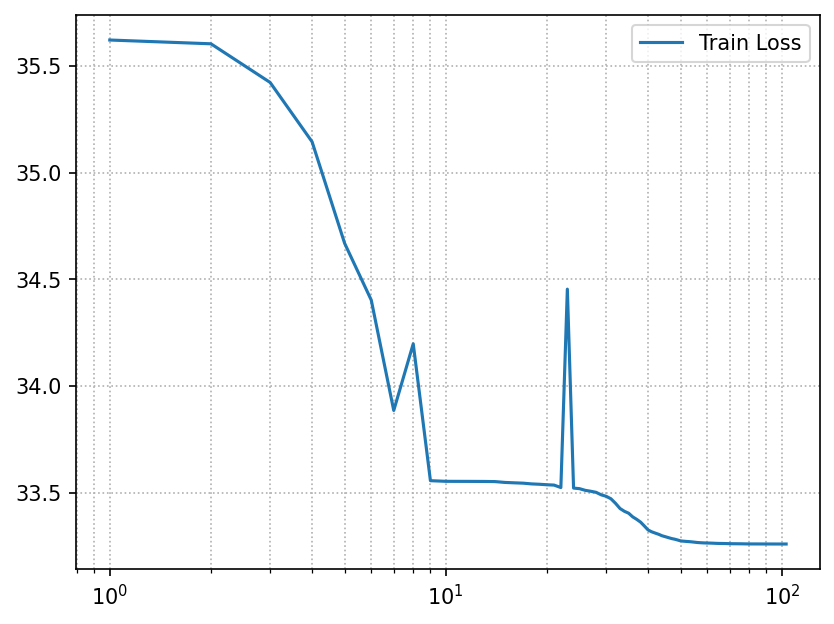

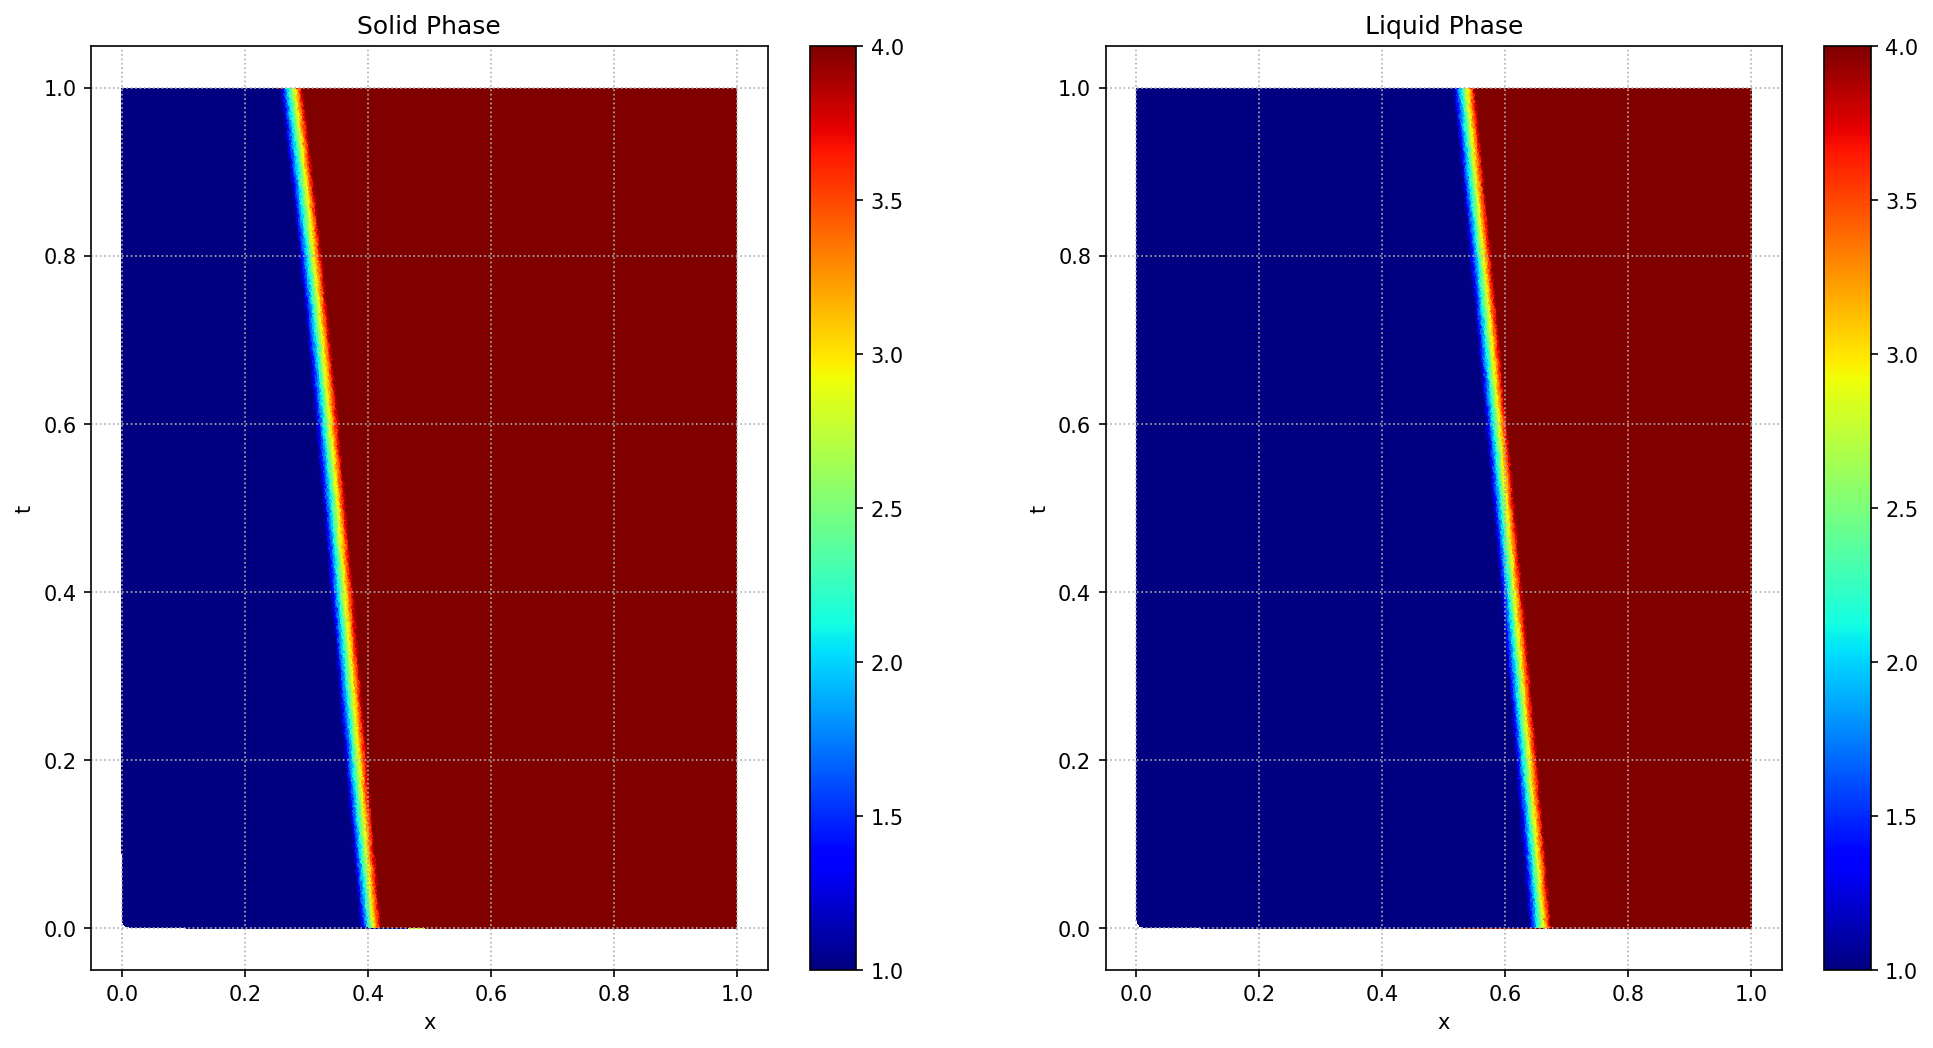

In [8]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

inputs = pinn.convert(pinn.soboleng.draw(100000).to('cuda'))

pred = pinn.approximate_solution(inputs)

solid = pred[:, 0]
liquid = pred[:, 1]

solid = solid.reshape(-1, )
liquid = liquid.reshape(-1, )

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].tripcolor(inputs[:, 1].detach().cpu(), inputs[:, 0].detach().cpu(), solid.detach().cpu(), cmap="jet", vmin=1, vmax=4)
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
axs[0].set_title("Solid Phase")

im2 = axs[1].tripcolor(inputs[:, 1].detach().cpu(), inputs[:, 0].detach().cpu(), liquid.detach().cpu(), cmap="jet", vmin=1, vmax=4)
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[1].set_title("Liquid Phase")

plt.show()


In [9]:
data = torch.from_numpy(np.genfromtxt("TestingData.txt", delimiter=',')[1:, :]).to('cuda').float()
t = data[:, 0]
x = data[:, 1]
print(t)
print(x)
pred = pinn.approximate_solution(data)

solid = pred[:, 0]
liquid = pred[:, 1]

FileNotFoundError: TestingData.txt not found.

In [ ]:
import pandas as pd
out = torch.stack([t, x, liquid, solid]).T
print(out)
out_df = pd.DataFrame(out.cpu().detach().numpy())
out_df.to_csv("Prediction.csv", index=False)